In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from ELMO import ELMo
import torch.nn.functional as F
from sts_loader import STSDataset, wo_ELMO_Dataset, tokenize, split_into_characters
from torch.utils.data import DataLoader

import wandb

c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(device)

cuda


In [3]:
# Load vocabularies
vocab = torch.load('../mar_word_vocab.pt')
character_vocab = torch.load('../mar_char_vocab.pt')

In [4]:
# Get Sentences and Scores

path = '../sts-train-mr.tsv'
sts_dataset = STSDataset(path)
s1, s2, scores = sts_dataset.format(char_vocab=character_vocab)
scores = torch.tensor(scores, dtype=torch.float32)

C:\Users\tanve\AppData\Local\Temp\ipykernel_16916\41700185.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float32)


In [5]:
# Get Sentences and Scores

path = '../sts-dev-mr.tsv'
sts_v_dataset = STSDataset(path)
s1_v, s2_v, scores_v = sts_v_dataset.format(char_vocab=character_vocab)
scores_v = torch.tensor(scores_v, dtype=torch.float32)

C:\Users\tanve\AppData\Local\Temp\ipykernel_16916\1309467377.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_v = torch.tensor(scores_v, dtype=torch.float32)


In [6]:
def create_dataloader(s1, s2, scores, batch_size):
    zipped = list(zip(s1, s2, scores))
    dataloader = DataLoader(zipped, batch_size=batch_size, shuffle=True)
    return dataloader

In [7]:
# make the dataloader for modle with elmo
s1_val = s1_v
s2_val = s2_v
scores_val = scores_v
batch_size = 128
val_dataloader = create_dataloader(s1_val, s2_val, scores_val, batch_size)
train_dataloader = create_dataloader(s1, s2, scores, batch_size)

In [8]:

path = '../sts-train-mr.tsv'
sts_dataset = wo_ELMO_Dataset(path,vocab)
s1, s2, scores = sts_dataset.format()
scores = torch.tensor(scores, dtype=torch.float32)

# Get Sentences and Scores

path = '../sts-dev-mr.tsv'
sts_v_dataset = wo_ELMO_Dataset(path,vocab)
s1_v, s2_v, scores_v = sts_v_dataset.format()
scores_v = torch.tensor(scores_v, dtype=torch.float32)

C:\Users\tanve\AppData\Local\Temp\ipykernel_16916\2472877923.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores, dtype=torch.float32)
C:\Users\tanve\AppData\Local\Temp\ipykernel_16916\2472877923.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_v = torch.tensor(scores_v, dtype=torch.float32)


In [9]:
# make the dataloader for model without elmo
sts_dataset = wo_ELMO_Dataset(path, vocab)
s1_val = s1_v
s2_val = s2_v
scores_val = scores_v
batch_size = 128
val_dataloader_wo_elmo = create_dataloader(s1_val, s2_val, scores_val, batch_size)
train_dataloader_wo_elmo = create_dataloader(s1, s2, scores, batch_size)

In [10]:
s1[2]

tensor([    12,    890,      0,   1261,   3120, 131034,      6,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1])

In [11]:
model = ELMo(cnn_config = {'character_embedding_size': 16, 
                           'num_filters': 32, 
                           'kernel_size': 5, 
                           'max_word_length': 10, 
                           'char_vocab_size': character_vocab.num_chars}, 
             elmo_config = {'num_layers': 3,
                            'word_embedding_dim': 150,
                            'vocab_size': vocab.num_words}, 
             char_vocab_size = character_vocab.num_chars).to(device)


In [12]:
model.load_state_dict(torch.load('../model_elmo_marathi.pt'))

<All keys matched successfully>

In [13]:
word_embedding_dim = 300

# Models

## ELMo

In [14]:
class SimilarityModel(nn.Module):
    def __init__(self, elmo):
        super(SimilarityModel, self).__init__()
        self.elmo = elmo        
        self.lambdas = nn.Parameter(torch.randn(3))
        self.lstm = nn.LSTM(word_embedding_dim, word_embedding_dim//2, batch_first=True, bidirectional=True, num_layers=1)

        for param in self.elmo.parameters():
            param.requires_grad = False
        
    def forward(self, sentence1, sentence2):
        forward_output1, backward_output1, final_embeddings1 = self.elmo(sentence1)
        encoding1 = torch.zeros_like(final_embeddings1[0])
        for i in range(3):
            encoding1 += self.lambdas[i] * final_embeddings1[i]

        forward_output2, backward_output2, final_embeddings2 = self.elmo(sentence2)
        encoding2 = torch.zeros_like(final_embeddings2[0])
        for i in range(3):
            encoding2 += self.lambdas[i] * final_embeddings2[i]

        lstm_out1, (hidden1, cell1) = self.lstm(encoding1)
        lstm_out2, (hidden2, cell2) = self.lstm(encoding2)
        
        lstm_out1 = lstm_out1.reshape(lstm_out1.size(0), -1)
        lstm_out2 = lstm_out2.reshape(lstm_out1.size(0), -1)  

        cos_sim = (F.cosine_similarity(lstm_out1, lstm_out2, dim=1) + 1)*5/2
        return cos_sim


In [15]:
wandb.join()

## Without ELMo

In [16]:
class SimilarityModel_wo_elmo(nn.Module):
    def __init__(self, vocab_size, word_embedding_dim, hidden_dim):
        super(SimilarityModel_wo_elmo, self).__init__()
        # Embedding layer with random initialization
        self.embedding = nn.Embedding(vocab_size, word_embedding_dim)
        # Bidirectional LSTM with specified hidden dimension
        self.lstm = nn.LSTM(word_embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=3)

    def forward(self, sentence1, sentence2):
        # Convert sentences to embeddings
        embeddings1 = self.embedding(sentence1)
        embeddings2 = self.embedding(sentence2)
        # print(embeddings1.shape)
        # print('wateva')
        # Pass the embeddings through the LSTM
        lstm_out1, _ = self.lstm(embeddings1)
        lstm_out2, _ = self.lstm(embeddings2)

        # print(lstm_out1.shape)

        # Aggregate LSTM outputs: take mean across sequence length
        # lstm_out1_mean = torch.mean(lstm_out1, dim=1)
        # lstm_out2_mean = torch.mean(lstm_out2, dim=1)

        lstm_out1 = lstm_out1.reshape(lstm_out1.size(0), -1)
        lstm_out2 = lstm_out2.reshape(lstm_out1.size(0), -1)

        # print(lstm_out1.shape)

        

        # Compute cosine similarity between aggregated LSTM outputs
        cos_sim = (F.cosine_similarity(lstm_out1, lstm_out2, dim=1) + 1) * 5 / 2

        return cos_sim


In [17]:
# similarity_model = SimilarityModel(model)
similarity_model = SimilarityModel(model).to(device)
similarity_model_wo_elmo = SimilarityModel_wo_elmo(vocab.num_words, word_embedding_dim, word_embedding_dim//2).to(device)

In [18]:
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(similarity_model.parameters(), lr=0.001)


In [19]:
num_epochs = 10

# train the model
def train(similarity_model, train_dataloader, val_dataloader, num_epochs):
    for epoch in range(num_epochs):
        similarity_model.train()
        total_loss = 0
        tdiff = 0
        for s1t, s2t, scorest in tqdm(train_dataloader):
            s1t = s1t
            s2t = s2t
            scorest = scorest.to(device)
            optimizer.zero_grad()
            # print(len(s1[0]))
            # stack the sentences
            s1t = torch.stack(s1t, dim=1).to(device)
            s2t = torch.stack(s2t, dim=1).to(device)
            outputs = similarity_model(s1t, s2t)
            # print(outputs.squeeze().shape, scores.shape)
            # print(outputs.shape, scores.shape)
            loss = criterion(outputs, scorest)
            tdiff += torch.abs(outputs - scorest).sum().item()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} Loss: {total_loss} Mean Difference: {tdiff/len(s1)}")

        train_loss = total_loss
        mean_diff = tdiff/len(s1)

        similarity_model.eval()
        with torch.no_grad():
            total_loss = 0
            # calculate mean difference between predicted and actual scores
            diff = 0

            for s1v, s2v, scoresv in val_dataloader:
                s1v = s1v
                s2v = s2v
                scoresv = scoresv.to(device)
                s1v = torch.stack(s1v, dim=1).to(device)
                s2v = torch.stack(s2v, dim=1).to(device)
                outputs = similarity_model(s1v, s2v)
                loss = criterion(outputs, scoresv)

                total_loss += loss.item()
                diff += torch.abs(outputs - scoresv).sum().item()
                # calculate 

            print(f"Validation Loss: {total_loss}" + f" Mean Difference: {diff/len(s1_val)}")

            val_loss = total_loss
            val_mean_diff = diff/len(s1_val)

        wandb.log({"train_loss": train_loss, "train_mean_diff": mean_diff, "val_loss": val_loss, "val_mean_diff": val_mean_diff})      

In [20]:
config = {'model': 'ELMo', 'language': 'Hindi', 'epochs': 50, 'batch_size': 128, 'lr': 0.001}

wandb.init(project='INLP-Project-ELMo', group= 'STS', name='Marathi with ELMo', config=config)

wandb.watch(similarity_model)

train(similarity_model, train_dataloader, val_dataloader, 10)

wandb.join()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanveer-mustafa (project-ai-scream). Use `wandb login --relogin` to force relogin


100%|██████████| 45/45 [03:55<00:00,  5.23s/it]


Epoch 0 Loss: 100.23750138282776 Mean Difference: 1.2138592368957477
Validation Loss: 25.479499101638794 Mean Difference: 1.2037144673665365


100%|██████████| 45/45 [03:42<00:00,  4.94s/it]


Epoch 1 Loss: 80.4619368314743 Mean Difference: 1.1011802975967184
Validation Loss: 24.82803750038147 Mean Difference: 1.1836604919433593


100%|██████████| 45/45 [03:46<00:00,  5.04s/it]


Epoch 2 Loss: 73.04929113388062 Mean Difference: 1.046334499606011
Validation Loss: 24.456581592559814 Mean Difference: 1.174253168741862


100%|██████████| 45/45 [04:01<00:00,  5.38s/it]


Epoch 3 Loss: 67.22169744968414 Mean Difference: 1.0036070019981476
Validation Loss: 24.283305883407593 Mean Difference: 1.1663210957845052


100%|██████████| 45/45 [03:40<00:00,  4.90s/it]


Epoch 4 Loss: 62.903103709220886 Mean Difference: 0.9676711839690504
Validation Loss: 24.413208723068237 Mean Difference: 1.1653148193359375


100%|██████████| 45/45 [03:40<00:00,  4.89s/it]


Epoch 5 Loss: 59.229310631752014 Mean Difference: 0.9383348094645522
Validation Loss: 24.173248052597046 Mean Difference: 1.160556167602539


100%|██████████| 45/45 [03:52<00:00,  5.17s/it]


Epoch 6 Loss: 56.06125271320343 Mean Difference: 0.9113916730250263
Validation Loss: 24.432723879814148 Mean Difference: 1.1621658121744791


100%|██████████| 45/45 [03:33<00:00,  4.74s/it]


Epoch 7 Loss: 52.43824291229248 Mean Difference: 0.879281791947165
Validation Loss: 24.45035696029663 Mean Difference: 1.165475077311198


100%|██████████| 45/45 [03:49<00:00,  5.09s/it]


Epoch 8 Loss: 50.271930515766144 Mean Difference: 0.8581859055043263
Validation Loss: 24.58637022972107 Mean Difference: 1.1663705444335937


100%|██████████| 45/45 [03:40<00:00,  4.90s/it]


Epoch 9 Loss: 48.30204528570175 Mean Difference: 0.8398127134425323
Validation Loss: 24.83904778957367 Mean Difference: 1.1659285939534505


train_loss,█▅▄▄▃▂▂▂▁▁
train_mean_diff,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▂▁▂▂▃▅
val_mean_diff,█▅▃▂▂▁▁▂▂▂
train_loss,48.30205
train_mean_diff,0.83981
val_loss,24.83905
val_mean_diff,1.16593


In [ ]:
# for config in configs:
#     wandb.init(project='sts_elmo', group= 'STS', name = 'Hindi with ELMo', config=config)
#     train_dataset = wo_ELMO_Dataset(path, vocab)
#     similarity_model = SimilarityModel(model).to(device)
#     optimizer = torch.optim.Adam(similarity_model.parameters(), lr=config['lr'])
#     train(similarity_model, train_dataloader, val_dataloader, config['epochs'])
#     wandb.finish()

In [27]:
num_epochs = 20

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(similarity_model_wo_elmo.parameters(), lr=0.001)

# train the model
def train_wo_elmo(similarity_model_wo_elmo, train_dataloader_wo_elmo, val_dataloader_wo_elmo, num_epochs):
    for epoch in range(num_epochs):
        similarity_model.train()
        total_loss = 0
        tdiff = 0
        for s1t, s2t, scorest in tqdm(train_dataloader_wo_elmo):
            s1t = s1t.to(device)
            s2t = s2t.to(device)
            scorest = scorest.to(device)
            optimizer.zero_grad()
            # print(len(s1t[0]))
            # stack the sentences
            # s1t = torch.stack(s1t, dim=1).to(device)
            # s2t = torch.stack(s2t, dim=1).to(device)
            outputs = similarity_model_wo_elmo(s1t, s2t)
            # print(outputs.squeeze().shape, scores.shape)
            # print(outputs.shape, scores.shape)
            loss = criterion(outputs, scorest)
            tdiff += torch.abs(outputs - scorest).sum().item()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} Loss: {total_loss} Mean Difference: {tdiff/len(s1t)}")
        train_loss = total_loss
        mean_diff = tdiff/len(s1)
        similarity_model.eval()
        with torch.no_grad():
            total_loss = 0
            # calculate mean difference between predicted and actual scores
            diff = 0

            for s1v, s2v, scoresv in val_dataloader_wo_elmo:
                s1v = s1v.to(device)
                s2v = s2v.to(device)
                scoresv = scoresv.to(device)
                # s1v = torch.stack(s1v, dim=1).to(device)
                # s2v = torch.stack(s2v, dim=1).to(device)
                outputs = similarity_model_wo_elmo(s1v, s2v)
                loss = criterion(outputs, scoresv)

                total_loss += loss.item()
                diff += torch.abs(outputs - scoresv).sum().item()
                val_loss = total_loss
                val_mean_diff = diff/len(s1_val)
                # calculate 

            print(f"Validation Loss: {total_loss}" + f" Mean Difference: {diff/len(s1v)}")
        wandb.log({"train_loss": train_loss, "train_mean_diff": mean_diff, "val_loss": val_loss, "val_mean_diff": val_mean_diff})      

In [28]:
config = {'model': 'ELMo', 'language': 'Hindi', 'epochs': 50, 'batch_size': 128, 'lr': 0.001}

wandb.init(project='INLP-Project-ELMo', group= 'STS', name='Marathi without ELMo', config=config)

wandb.watch(similarity_model_wo_elmo)

train_wo_elmo(similarity_model_wo_elmo, train_dataloader_wo_elmo, val_dataloader_wo_elmo, 10)

wandb.join()

100%|██████████| 45/45 [00:02<00:00, 18.72it/s]


Epoch 0 Loss: 137.5936574935913 Mean Difference: 67.02966908511952
Validation Loss: 29.159468173980713 Mean Difference: 20.55662959554921


100%|██████████| 45/45 [00:02<00:00, 20.36it/s]


Epoch 1 Loss: 81.84941828250885 Mean Difference: 52.85890086899456
Validation Loss: 27.19324517250061 Mean Difference: 19.82845978114916


100%|██████████| 45/45 [00:02<00:00, 21.12it/s]


Epoch 2 Loss: 55.960001826286316 Mean Difference: 43.34597360985911
Validation Loss: 26.625881791114807 Mean Difference: 19.568138703056004


100%|██████████| 45/45 [00:01<00:00, 23.06it/s]


Epoch 3 Loss: 36.73254865407944 Mean Difference: 34.69818363026676
Validation Loss: 28.40826714038849 Mean Difference: 20.170428566310715


100%|██████████| 45/45 [00:02<00:00, 22.37it/s]


Epoch 4 Loss: 23.37160512804985 Mean Difference: 27.383331233619625
Validation Loss: 27.826963305473328 Mean Difference: 19.87008053323497


100%|██████████| 45/45 [00:02<00:00, 21.04it/s]


Epoch 5 Loss: 14.81920151412487 Mean Difference: 21.55700654249925
Validation Loss: 27.694105863571167 Mean Difference: 19.7839412689209


100%|██████████| 45/45 [00:02<00:00, 21.02it/s]


Epoch 6 Loss: 9.553726121783257 Mean Difference: 16.920278891538963
Validation Loss: 27.129385828971863 Mean Difference: 19.518521682075832


100%|██████████| 45/45 [00:02<00:00, 21.24it/s]


Epoch 7 Loss: 6.7596956342458725 Mean Difference: 14.038569898686857
Validation Loss: 27.47385346889496 Mean Difference: 19.71524197122325


100%|██████████| 45/45 [00:02<00:00, 21.63it/s]


Epoch 8 Loss: 5.474012479186058 Mean Difference: 12.779764126508663
Validation Loss: 27.37376618385315 Mean Difference: 19.706866057022758


100%|██████████| 45/45 [00:02<00:00, 20.62it/s]


Epoch 9 Loss: 4.9657799899578094 Mean Difference: 12.016459065624792
Validation Loss: 28.353691458702087 Mean Difference: 19.99085401452106


train_loss,█▅▄▃▂▂▁▁▁▁
train_mean_diff,█▆▅▄▃▂▂▁▁▁
val_loss,█▃▁▆▄▄▂▃▃▆
val_mean_diff,█▃▁▅▃▃▁▂▂▄
train_loss,4.96578
train_mean_diff,0.24455
val_loss,28.35369
val_mean_diff,1.22611


In [25]:
kitna = "कितना"
milta = "मिलता"
hai = "है"
se = "से"
bhookh = "भूख"
bhookha = "भूखा"
pyaas = "प्यास"
imarat = "इमारत"

mujhe = "मुझे"
lag = "लग"
rahi = "रही"

aur = "और"

jaise = "जैसे"
to = "तो"
waise = "वैसे"
hi = "ही"
mere = "मेरे"
bhai = "भाई"

bahan = "बहन"
aa= "आ"
rahe = "रहे"
hain = "हैं"

machwara = "मच्छरा"
machli = "मछली"
paani = "पानी"
mein = "में"
pakadne = "पकड़ने"
jaata = "जाता"
hai = "है"

sen = [machwara + " " + machli + " " + paani + " " + mein + " " + pakadne + " " + jaata + " " + hai]

sentence1 = [mere + " " + bhai + " " + aur + " " + bahan + " " + aa + " " + rahe + " " + hain]

# merge the words into a single string
sentence = [mujhe + " " + bhookh + " "+ aur +" " + pyaas+" " + lag + " " +rahi + " " + hai]
# sentence1 = sen

In [26]:
sentence1

['मेरे भाई और बहन आ रहे हैं']

In [264]:
t = tokenize(sentence1)
t

[['मच्छरा', 'मछली', 'पानी', 'में', 'पकड़ने', 'जाता', 'है']]

In [265]:
t = tokenize(sentence1)
t = split_into_characters(t, character_vocab, word_length=7, sen_len=7)

In [266]:
t[0]

[[13, 30, 6, 55, 4, 2, 0],
 [13, 55, 15, 7, 0, 0, 0],
 [17, 2, 8, 7, 0, 0, 0],
 [13, 5, 11, 0, 0, 0, 0],
 [17, 3, 33, 52, 8, 5, 0],
 [21, 2, 14, 2, 0, 0, 0],
 [12, 25, 0, 0, 0, 0, 0]]

In [267]:
# convert t to a list of tensors
for i in range(len(t)):
    t[i] = torch.tensor(t[i]).to(device)

In [268]:
t

[tensor([[13, 30,  6, 55,  4,  2,  0],
         [13, 55, 15,  7,  0,  0,  0],
         [17,  2,  8,  7,  0,  0,  0],
         [13,  5, 11,  0,  0,  0,  0],
         [17,  3, 33, 52,  8,  5,  0],
         [21,  2, 14,  2,  0,  0,  0],
         [12, 25,  0,  0,  0,  0,  0]], device='cuda:0')]

In [269]:
sentence_tensor = torch.stack(t, dim=1)

In [270]:
forward_output, backward_output, final_embeddings = model(sentence_tensor)

In [272]:
cos_vals = []
for i in range(7):
    temp = []
    for j in range(7):
        e1 = final_embeddings[-1][i][0]
        e2 = final_embeddings[-1][j][0]
        temp.append(F.cosine_similarity(e1, e2, dim=0).item())
    cos_vals.append(temp)
    

In [273]:
# for indices between 0 and 6, make a dictionary of mapping them to words of sentence
word_map = {}
for i in range(7):
    word_map[i] = sentence[0].split()[i]

In [274]:
word_map

{0: 'मुझे', 1: 'भूख', 2: 'और', 3: 'प्यास', 4: 'लग', 5: 'रही', 6: 'है'}

findfont: Font family 'Tiro Devanagari Hindi' not found.
findfont: Font family 'Tiro Devanagari Hindi' not found.
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.draw()
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.draw()
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from current font.
  fig.canvas.draw()
c:\Users\tanve\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2375 (\N{DEV

<Axes: >

findfont: Font family 'Tiro Devanagari Hindi' not found.
C:\Users\tanve\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  func(*args, **kwargs)
C:\Users\tanve\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
C:\Users\tanve\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  func(*args, **kwargs)
C:\Users\tanve\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from current font.
  func(*args, **kwargs)
C:\Users\tanve\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  func(*args, **

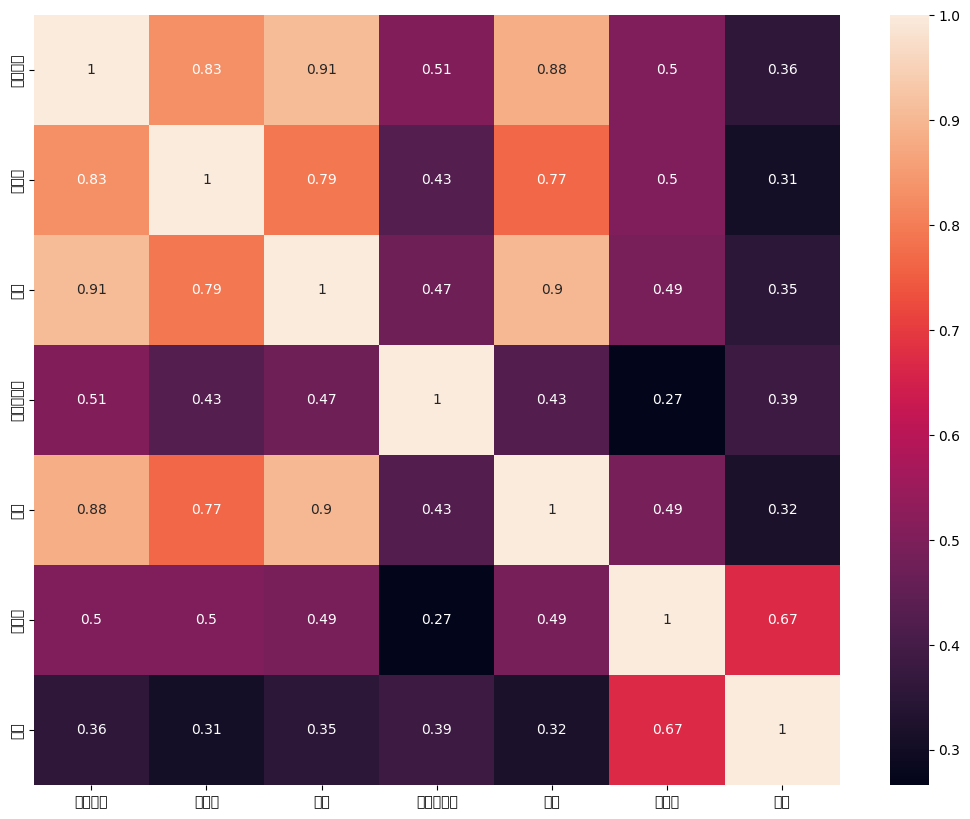

In [275]:
# make a heatmap of cosine similarities and annotate with words
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
# show the values in the heatmap
sns.heatmap(cos_vals, annot=True, xticklabels=[word_map[i] for i in range(7)], yticklabels=[word_map[i] for i in range(7)])
